<a href="https://colab.research.google.com/github/Lawyerd/machine_learning_basic/blob/main/7_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `7.1` 신경망 모델


In [7]:
import numpy as np

# 데이터 생성
np.random.seed(seed=1)
N = 200 # 데이터의 개수
K = 3 # 분포의 수
T = np.zeros((N,3), dtype=np.uint8)
X = np.zeros((N,2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-.5, -.5], [.5,1.0], [1,-.5]])
Sig = np.array([[.7,.7], [.8, .3], [.3, .8]])
Pi = np.array([0.4, 0.8, 1])
for n in range(N) : 
  wk = np.random.rand()
  for k in range(K) : 
    if wk < Pi[k] : 
      T[n, k] = 1
      break
  for k in range(2) : 
    X[n, k] = np.random.randn() * Sig[T[n,:] == 1, k ] + Mu[T[n,:]== 1, k]

In [8]:
# 데이터를 훈련 데이터와 테스트 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training,:]
X_test = X[X_n_training:,:]
T_train = T[:X_n_training,:]
T_test = T[X_n_training:,:]

# 데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train =X_train, T_train = T_train, X_test = X_test, T_test= T_test, X_range0 = X_range0, X_range1 = X_range1)

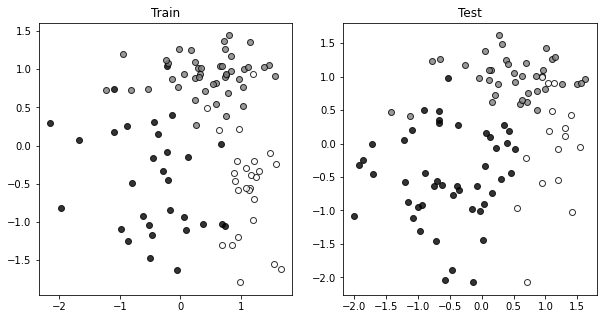

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 시각화
def Show_data(ax, x, t) : 
  wk, n = t.shape
  c = [[0,0,0],[.5,.5,.5],[1,1,1]]
  for i in range(n):
    ax.plot(x[t[:,i]==1,0], x[t[:,i]==1,1], color = c[i], linestyle='none', marker='o', markeredgecolor='black', alpha=0.8)

# 메인
plt.figure(1, figsize=(10,5))
Ax = plt.subplot(1,2,1)
plt.title("Train")
Show_data(Ax, X_train, T_train)


Ax = plt.subplot(1,2,2)
Show_data(Ax, X_test, T_test)
plt.title("Test")

plt.show()

### 신경망의 구현

> 입력층(출력) 
- $x_0$ ~ $x_{D+1}$ 
- [$N * D+1$ 행렬] (데이터의 개수 * (차원의 개수 + 1))
- $x_{D+1}$는 항상 1


> 중간층(매개변수) 
- $w_{00}$ ~ $x_{D+1, M}$ 
- [$D+1 * M$ 행렬] ((입력 차원의 개수 + 1), 중간층의 개수)
- $i$번째 입력층의 출력($x_{i}$)에서 $j$번째 중간층의 입력($b_{j}$)으로 전달될 때 붙는 매개변수 : $w_{ij}$

> 중간층(입력) 
- $b_{0}$ ~ $b_{M}$ 
- [$N * M$ 행렬] (데이터의 개수 * 중간층의 개수)
- $x_{0} * w_{01} = b_{1}$  

> 중간층(출력) 
- $z_{0}$ ~ $z_{M+1}$ 
- 더미 데이터 $z_{M+1} = 1$추가
- [$N * M+1$ 행렬] (데이터의 개수 * (중간층의 개수 + 1))
- $\exp(b_{1}) = z_1$  

> 출력층(매개변수) 
- $v_{00}$ ~ $v_{D+1, K}$ 
- [$D+1 * K$ 행렬] ((입력 차원의 개수 + 1), 출력층의 개수)
- $i$번째 중간층의 출력($z_{i}$)에서 $j$번째 출력층의 입력($a_{j}$)으로 전달될 때 붙는 매개변수 : $v_{ij}$

> 출력층(입력) 
- $a_{0}$ ~ $a_{K}$ 
- [$N * K$ 행렬] (데이터의 개수 * 출력층의 개수)
- $z_{0} * v_{01} = a_{1}$  

> 출력층(출력) 
- $y_{0}$ ~ $y_{K}$ 
- [$N * K$ 행렬] (데이터의 개수 * 출력층의 개수)
- $y_k = \frac{\exp{a_k}}{\sum_{i=0}^{K-1}\exp(a_i)}$, 입력을 소프트맥스 함수에 집어넣은 함수 


$$
b_j = \sum_{i=1}^{D+1}w_{ji}x_i
$$

$$
\begin{bmatrix}
b_0  \\
\vdots  \\
b_M
\end{bmatrix}
=
\begin{bmatrix}
w_{00} & \cdots & w_{0,D+1} \\
\vdots & \ddots & \vdots \\
w_{M0} & \cdots & w_{M,D+1}
\end{bmatrix}
\begin{bmatrix}
x_0  \\
\vdots  \\
x_{D+1}
\end{bmatrix}
$$

In [39]:
def Sigmoid(x) : 
  y = 1 / (1 + np.exp(-x))
  return y
# x * w = b -> z
# z * v = a -> y
# x : 입력 데이터        : N * D

# w : 중간층의 매개 변수 : M * (D+1) // 저장할 때는 (D+1) * M으로 저장함
# b : 중간층의 입력 총합 : N * M 
# z : 중간층의 출력 총합 : Sigmoid(b) = Sigmoid(N * M)

# v : 출력층의 매개 변수 : K * (M+1) // 저장할 때는 (M+1) * K로 저장함
# a : 출력층의 입력 총합 : N * K
# y : 출력층의 출력 총합 : sigmoid

# A+1층의 입력 총합  = (A+1층의 매개 변수) * (A층의 출력 총합)
# [K, 1] = [K]
def FNN(wv, M, K, x) : 
  # M은 중간층의 개수
  # K는 출력층의 개수
  N, D = x.shape # 입력 차원, N = 입력 데이터의 개수, D는 입력 차원,
  w = wv[:M * (D+1)]
  w = w.reshape(M, (D+1))
  v = wv[M * (D+1):]
  v = v.reshape(K, (M+1))
  z = np.zeros((N, M+1))
  b = np.zeros((N, M+1))
  a = np.zeros((N, K))
  y = np.zeros((N, K))
  for n in range (N) :
    # 중간층의 계산
    for m in range (M) : 
      b[n, m] = np.dot(w[m,:], np.r_[x[n, :],1])
      z[n, m] = Sigmoid(b[n,m])
    z[n,M] = 1
    wkz = 0
    for k in range(K) :
      a[n, k] = np.dot(v[k, :], z[n, :]) # v행렬에서 뽑은 k열과 z행렬에서 뽑은 n열을 서로 곱해서 a[n, k]에 저장
      wkz = wkz + np.exp(a[n,k])
    for k in range(K) : 
      y[n, k] = np.exp(a[n, k]) / wkz # 출력층의 출력에는 시그모이드 함수를 사용하는 것이 아니라 소프트맥스 함수를 출력한다. 
  return y, a, z, b # 전부 N * K 행렬

WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

### 수치 미분법
이제까지 신경망 모델을 구했다.이제 수치 미분법을 통해 최적의 매개변수 $W$를 찾아본다.

복습하자면, 수치 미분법을 적용할 함수는 오차 함수이다. 특정 함수의 극소값을 구할 수 있기 때문에 수치미분법을 사용한다. 따라서 오차함수를 먼저 정의한 후 그 함수를 미분하여 오차를 가장 최소로 만드는 지점을 찾고, 그 결과를 도출하는 매개변수 $W$를 구하면 된다. 

그러면 오차함수를 어떻게 정의하느냐가 관건인데, 분류 문제이기 때문에 '평균 교차 엔트로피 함수'를 사용한다. 

> 평균 교차 엔트로피 함수

$$
E({\bf w}, {\bf v}) = -\frac{1}{N}\sum_{n=0}^{N-1}\sum_{k=0}^{K-1}t_{nk}\log(y_{nk})
$$

이 평균 교차 엔트로피 오차를 다음과 같이 구현한다.

In [11]:
# 평균 교차 엔트로피 함수
def CE_FNN(wv, M, K, x, t) : 
  # wv, M, K는 매개변수가 몇 개인지 관련이 있기 때문에 항상 가져온다.
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x) # 행렬 형태로 y와 t가 반환됨
  ce = -np.dot(np.log(y.reshape(-1)),t.reshape(-1)) / N
  return ce ## 평균 오차를 반환함

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X, T)

1.0986122886681096

### 미분하지 않고도 근사치를 구하는 방법

그런데 우리는 평균 교차 엔트로피 함수를 미분하지 않고도 접선의 기울기를 구할 수 있다. 

예를 들어, 오차함수 $E(w)$를 상정한다. 그리고 $w$는 $w^*$라는 값을 가지고 있다고 가정한다. 경사 하강법은 $w^*$ 지점에서 $E(w)$의 $w$에 관한 편미분 $\partial E / \partial w$를 계산하고 거기에 마이너스를 곱한 방향으로 $w^*$를 갱신한다.

그러나 성실하게 미분하고 기울기를 계산하지 않아도 $w^*$의 조금 앞의 지점 ($w^*-\epsilon$)에서의 $E(w^*-\epsilon)$를 구하고, 마찬가지로 조금 뒤의 지점  $E(w^*+\epsilon)$을 구하면 기울기를 근사할 수 있다. 

$$
\frac {\partial E}{\partial w} |_{w^*} \cong \frac{E(w^*+\epsilon) - E(w^*-\epsilon)}{2\epsilon}
$$

그런데 실제로는 매개 변수가 하나가 아니라 여러 개이다. 따라서 현재의 점에서 기울기를 알기 위해서는 세 개의 매개 변수에 대한 편미분 근사를 모두 진행해야 한다.

$w_1^*$$,w_2^*$의 값은 고정한 후 $w_0^*$에 대한 기울기를 근사한다. $w_1, w_2$에 대해서도 마찬가지로 그 외의 매개 변수를 고정한 후에 편미분을 구한다.

</br></br>

> 특징

이 방법의 단점은 예상처럼 정확도에 있는 것이 아니라 계산 비용에 있다. 근사하는 방법이기 때문에 정확도가 떨어질 것이라 생각했지만, 어느정도의 정확도는 보장된다. 다만, 한 매개 변수의 미분을 계산하기 위해서 두 번의 $E$계산이 필요하다. 따라서 계산 비용이 많이 든다.

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944]
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


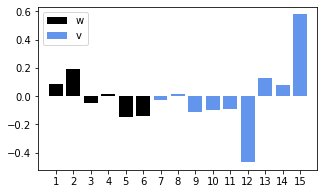

In [12]:
def dCE_FNN_num(wv, M, K, x, t) : 
  # wv는 w + v를 합한 총 매개 변수의 개수
  epsilon = 0.001
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)) :
    wv_modified = wv.copy()
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t) # E(w^* - epsilon) 계산
    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t) # E(w^* + epsilon) 계산
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

def Show_WV(wv, M) : # w와 v 매개변수가 어떤 값을 갖고 있는지 그림으로 그려준다.
  N = wv.shape[0]
  plt.bar(range(1, M*3 + 1), wv[:M * 3], align='center', color='black', label = 'w')
  plt.bar(range(M * 3 + 1, N + 1), wv[M*3:], align='center', color='cornflowerblue', label ='v') 
  plt.legend(loc  ='upper left')
  plt.xticks(range(1, N+1))
  plt.xlim(0, N+1)

M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV) # 평균, 표준편차, 인덱스의 개수를 입력하면 자동으로 해당 배열 생성, 
# WV = W의의 초기값
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :]) # 미분된 값
print(WV)
print(dWV)
plt.figure(1, figsize=(5,3))
Show_WV(dWV, M)
plt.show()

### 수치 미분법에 의한 경사 하강법
이제 이 함수를 갖고 분류 문제를 경사 하강법으로 풀 것이다. 

지금까지와 다른 부분은 입력에 학습시키는 가중치의 초기값으로 wv_init을 넣는다는 것이다. 
또 훈련 데이터뿐만 아니라 테스트 데이터도 입력한다. 이것은 학습 단계별로 테스트 데이터의 오차도 체크해 오버 피팅이 일어나고 있지 않은지 확인하기 위해서이다. 물론 테스트 데이터의 정보는 매개 변수의 학습에는 사용하지 않는다. 

- n : 학습 단계
- alpha : 학습 상수
- 함수의 출력 값 : 최적화된 매개 변수 wvt 

In [13]:
import time

def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha) : # n은 학습 단계, alpha는 학습률
  wvt = wv_init
  err_train = np.zeros(n) # 각 학습 단계 별로 에러 값을 저장하기 위해서
  err_test = np.zeros(n)

  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n) : # 학습 단계의 수만큼 반복
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train) # 매개변수 wvt를 (미분한 값 * 학습률) 만큼 변경시킴
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train) # 매개변수 wvt를 사용하여 train set을 돌렸을 때 나오는 오차
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)    # 매개변수 wvt를 test set에 적용하였을 때 오차 
    wv_hist[i, :] = wvt # 매개변수의 변화 값을 배열에 저장

  return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M+1))
N_step = 1000 # 학습 단계
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN_num(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime # 계산하는데 걸리는 시간 측정
print("Calculation Time :",calculation_time) # 192초 걸림

Calculation Time : 209.08575630187988


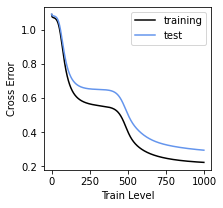

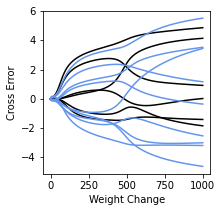

In [14]:
# 학습 오차의 표시
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label = 'training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.xlabel('Train Level')
plt.ylabel('Cross Error')

plt.legend()

plt.figure(2, figsize=(3,3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M* 3 :], 'cornflowerblue')
plt.xlabel('Weight Change')
plt.ylabel('Cross Error')
# plt.legend()
plt.show()

0 주변의 기본 값으로 시작된 가중치는 시간이 지남에 따라 각각 특정 값으로 수렴하고 있다. 그러나 자세히 살펴보면 400단계 부근에서 각각의 가중치 그래프가 교차하고 있음을 알 수 있다. 

이것은 가중치를 갱신하는 방향, 즉 오차 함수의 기울기의 방향이 변화하는 것을 의미한다. 이는 가중치가 `안장점`이라는 지점을 통과했기 때문이다. 

> 안장점

어느 방향은 계곡, 다른 방향으로는 산이 되는 지점이다. 현재 그래프에서는 가중치 공간이 15차원이기 때문에 오차 함수를 그릴 수는 없지만 만약 2차원이라면 다음과 같이 그릴 수 있다. 
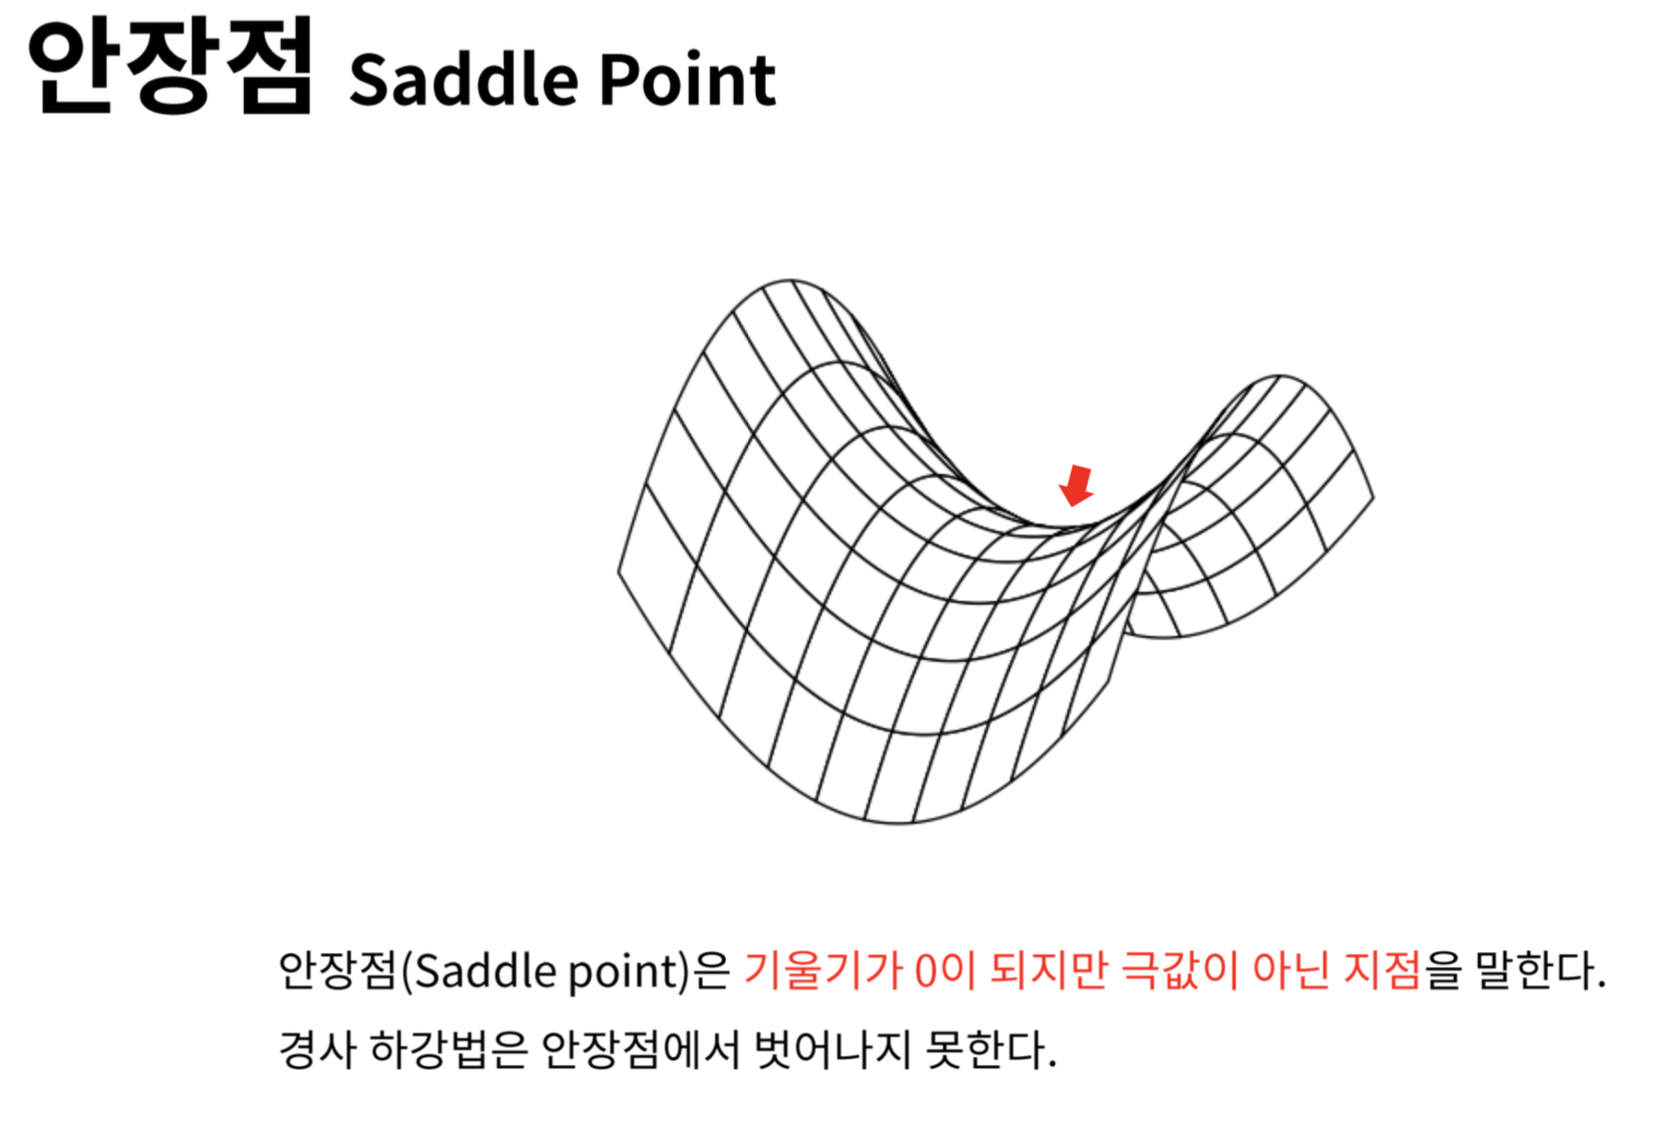
https://heung-bae-lee.github.io/image/Saddle_point.png


경사 하강법에 따라 가중치는 계곡의 중심을 향해 나아가고 있지만, 중심에 가까워질수록 기울기는 작아지고, 갱신도 느려진다. 그러나 어느정도 진행되면 거기에서 점차 방향이 변화하고, 또 갱신이 가속화된다. 

신경망에 의해 만들어지는 오차 함수의 지형은 복잡하다. 비선형성이 강한 신경망의 경우는 일단 학습이 수렴해도 멈추지 않고 더 노력하면 학습이 단숨에 진행되는 경우가 많다. 즉, 학습이 다 이루어졌다고 생각했는데 더 발전될 여지가 많이 남아 있는 경우가 있을 때가 많다. 따라서 신경망의 학습 단계의 수를 결정하는 것은 상당히 어려운 문제이다. 


그런데, 오차와 가중치만으로는 네트워크가 정말로 학습했다는 실감이 나지 않는다. 그래서 데이터 공간을 클래스 0, 1, 2로 판정하는 영역의 경계선을 표시해보자

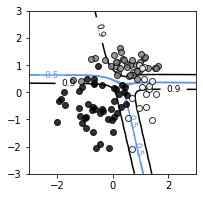

In [15]:
def show_FNN(wv, M, K) : 
  xn = 60
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1) # xx0, xx1 = 60 * 60 행렬
  xx0_ = np.reshape(xx0, xn * xn, 'F') # xx0을 3600 * 1 행렬으로 재배열한 것 (F)의 순서로 

  # 여기서 F의 순서가 뭐냐면, 일단 행렬 두개를 위 아래로 붙였는데, 그냥 재배열을 하게 되면 첫번째 행렬부터 쫙 나열이 된다.
  # 그런데 F의 순서로 배열을 나열하면 첫번째 행렬 하나, 두번째 행렬 하나, 첫번째 행렬에서 다시 하나 이런 순서대로 재배열이 된다. 
  # 그러니까 정리하면 이렇게 될 것이다.
  # [[1번째 행렬의 1번, 2번째 행렬의 1번], 
  # [1번째 행렬의 2번],
  #  ..., 
  # [2번째 행렬의 30번], 
  # ..., 
  # [1번째 행렬의 3571번], 
  # ... 
  # [2번째 행렬의 3600번]]
  xx1_ = np.reshape(xx1, xn * xn, 'F') # xx1을 3600 * 1 행렬으로 재배열한 것
  x = np.c_[xx0_, xx1_] # c_는 두 개의 행렬을 좌우로 붙이는 함수 => x = 3600 * 2 함수
  # x 는 입력 데이터인데, 입력 데이터의 갯수가 3600개이고 입력 차원 D = 2인 데이터 행렬이다.
  y, a, z, b = FNN(wv, M, K, x) # 신경망 모델에서 출력값을 y에 담음 x가 3600 * 2이니 y도 [3600 * k] 행렬
  # print(y) #  y = N * K 행렬이다. N은 데이터의 개수, K는 출력층의 출력의 갯수 
  plt.figure(1, figsize=(4, 4))
  for ic in range(K) : 
    f = y[:, ic] # y의 모든 데이터에 대해 ic번째 열을 정렬한 것, 즉 N이 3600개이니, 3600개의 행에 대해 ic번째 열을 모두 뽑은 것
    # [3600 * 1]의 행렬
    f = f.reshape(xn, xn) # 다시 [60 * 60]행렬로 만들어버림
    f = f.T # transpose하는 함수 F의 순서로 재배열했으니까 Transpose해줘야한다. 
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors =['cornflowerblue', 'black'])
    cont.clabel(fmt = '%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

plt.figure(1, figsize=(3,3))
AX = plt.subplot(1,1,1)
Show_data(AX, X_test, T_test)
show_FNN(WV, M, K)
plt.show()

위와 같이 분류되었음을 알 수 있다.

### 오차 역전파법
수치 미분은 실행속도가 느리다. 그래서 편미분을 해석적으로 구하여 실행 속도를 빠르게 한다.

피드 포워드 신경망에 학습시키는 방법으로 오차 역전파법을 사용한다.
> 오차 역전파법

네트워크 출력에서 발생하는 오차(지도 신호와의 차이)의 정보를 사용하여, 출력 층의 가중치 $v_{kj}$에서 중간층에 가중치 $w_{ji}$으로 입력 방향의 반대로 가중치를 갱신해 나가기 때문에 이런 이름이 붙었다.

사실 오차 역전파법은 경사 하강법이다. 경사 하강법을 피드포워드 네트워크에 적용하면 오차 역전파법이 자연스럽게 도출된다.

경사 하강법을 적용하기 위해 오차 함수를 매개 변수로 편미분한다. 우선 네트워크 분류를 하기 때문에 오차함수는 다음과 같은 평균 교차 엔트로피 오차를 생각한다. 

$$
E({\bf w},{\bf v}) = - \frac{1}{N} \sum_{n = 0}^{N-1} \sum_{k = 0}^{K-1} t_{nk}\ln(y_{nk})
$$

우선 하나의 데이터 $n$에만 해당하는 상호 엔트로피 오차$E_n$을 다음과 같이 정의한다. 
$$
E_n({\bf w},{\bf v}) = - \sum_{k = 0}^{K-1} t_{nk}\ln(y_{nk})
$$
그러면 평균 교차 엔트로피 오차를 다음과 같이 나타낼 수 있다. 
$$
E({\bf w},{\bf v}) = - \frac{1}{N} \sum_{n = 0}^{N-1} E_n({\bf w},{\bf v})
$$

즉, 평균 교차 엔트로피 오차는 데이터 각각의 교차 엔트로피 오차의 평균으로 해석된다. 경사 하강법에서 사용하는 $E$의 매개 변수($w$)의 편미분은, 예를 들어 $\partial E / \partial w_{ji}$ 를 고려했을 때 합과 미분은 교환할 수 있기 때문에 각 데이터 $n$에 대한  $\partial E_n / \partial w_{ji}$ 을 구한 후 평균을 내어  $\partial E / \partial w_{ji}$ 를 구할 수 있다. 
$$
 \frac{\partial E}{ \partial w_{ji}} = \frac{\partial}{ \partial w_{ji}}\frac{1}{N}\sum_{n=0}^{N-1}E_n = \frac{1}{N}\sum_{n=0}^{N-1}\frac{\partial E_n}{ \partial w_{ji}}
$$

따라서 $\partial E_n / \partial w_{ji}$를 구하는 것을 목표로 한다. 

그런데 네트워크 매개 변수는 $w$뿐만 아니라, $v$도 있다. 여기서는 $D = 2, M = 2, K = 3$의 경우를 상정한다. 따라서 우선 $E_n$을 $v_{kj}$로 편미분한 식을 구한 후 다음으로 $E_n$을 $w_{kj}$로 편미분한 식을 구하는 순서로 진행된다.      


###  $\partial E_n / \partial v_{ji}$ 구하기
편미분의 연쇄법칙을 사용하여  $\partial E_n / \partial v_{ji}$ 식을 다음과 같이 분해한다. 
$$
\frac{\partial E_n}{\partial v_{ji}} = \frac{\partial E_n}{\partial a_{k}}\frac{\partial a_{k}}{\partial v_{kj}}
$$

두 항의 곱으로 나타나있기 때문에 두 항을 각각 구한 후 곱하면 답을 구할 수 있다. 먼저 $\frac{\partial E_n}{\partial a_{k}}$부터 구해보자 (구하는 방법은 먼저 $k=0$일때의 값을 먼저 구한 후 일반화를 진행할 것이다.)

$$
\frac{\partial E_n}{\partial a_{0}} = \frac{\partial}{\partial a_0}(-t_0\log y_0 - t_1\log y_1 - t_2\log y_2)
$$

$t_k$는 지도 신호이기 때문에 $a_0$이 포함되지 않는다. 따라서 상수로 취급한다. 하지만 $y_k$는 입력 총합 $a_0$과 관계하고 있다. 따라서 위 식을 다음과 같이 확장할 수 있다. 

$$
\frac{\partial E_n}{\partial a_{0}} = -t_0\frac{1}{y_0}\frac{\partial y_0}{\partial a_0}-t_1\frac{1}{y_1}\frac{\partial y_1}{\partial a_0}-t_2\frac{1}{y_2}\frac{\partial y_2}{\partial a_0}
$$

[참고 : $y'(x) = (\log(x))' = 1/x$]

또한 $\frac{\partial y_0}{\partial a_0}$ 부분은 $y$가 $a$의 소프트맥스 함수로 만들어져 있기 때문에, 다음과 같이 변형할 수 있다.
$$
\frac{\partial y_0}{\partial a_0} = y_0(1 - y_0)
$$

마찬가지로 2항, 3항도 다음과 같이 표현할 수 있다. 
$$
\frac{\partial y_1}{\partial a_0} = y_0y_1
$$

$$
\frac{\partial y_2}{\partial a_0} = y_0y_2
$$

즉 세 항을 모두 대체하면 $\frac{\partial E_n}{\partial a_{0}}$는 다음과 같이 정리된다. 

$$
\frac{\partial E_n}{\partial a_{0}} = y_0 - t_0
$$

$k = 1,2$인 경우에도 동일한 패턴으로 답이 나온다. 그러면 다음과 같이 일반화해보자
$$
(1)\quad\frac{\partial E_n}{\partial a_{k}} = y_k - t_k = \delta_k^{(2)}
$$

$ \delta_k^{(2)}$는 출력층 (2층)의 오차를 나타내므로 위와 같이 표기하였다. 

덧붙여서, 우리는 오차함수로 '교차 엔트로피 오차 함수(CEE)'를 사용하였기에 $
\frac{\partial E_n}{\partial a_{k}} = y_k - t_k = \delta_k^{(2)}
$이러한 결과가 나온 것이다. 만약 '교차 엔트로피 함수(CEE)'가 아닌 '제곱 오차 함수(MSE)'를 사용했다면, 아래와 같이 얻을 수 있다. 
$$
\frac{\partial E_n}{\partial a_{k}} = (y_k - t_k)h'(a_k) = \delta_k^{(2)}
$$
즉, 당연한 이야기겠지만 어떤 함수를 오차 함수로 사용하느냐에 따라 오차 함수를 매개 변수로 나눈 값은 달라진다. 

그러면 이제 후반부에 있는 $\frac{\partial a_{k}}{\partial v_{kj}}$ 이 녀석을 구해보자 
이번에도 $k=0$인 경우를 먼저 구한 후 일반화를 진행할 것이다. 

$$
a_0 = v_{00}z_0 + v_{01}z_1 + v_{02}z_2
$$
그래서 아래와 같이 정리된다.
$$
\frac{\partial a_{0}}{\partial v_{00}} = z_0, \quad \frac{\partial a_{0}}{\partial v_{01}} = z_1, \quad \frac{\partial a_{0}}{\partial v_{02}} = z_2
$$

위 식을 일반화하면 아래와 같다. 
$$(2)\quad
\frac{\partial a_{k}}{\partial v_{kj}} = z_j
$$

이제 식(1)과 식(2)를 곱하면 $\partial E_n / \partial v_{ji}$를 구할 수 있다. 
$$
\frac{\partial E_n}{\partial v_{ji}} = 
\frac{\partial E_n}{\partial a_{k}}\frac{\partial a_{k}}{\partial v_{kj}} = (y_k - t_k)z_j = \delta_k^{(2)}z_j
$$

따라서 $v_kj$의 갱신 규칙은 다음과 같다. 
$$
v_{kj}(t+1) = v_{kj}(t) - \alpha\frac{\partial E_n}{\partial v_{kj}} = v_{kj}(t) - \alpha\delta_k^{(2)}z_j
$$



> 해석

$z_j = \sigma (b_j)$이기 때문에 항상 0 ~ 1 사이의 양수이다. 시그모이드의 출력 값은 항상 0 ~ 1사이의 양수이다.

출력 $y_k$가 목표 데이터 $t_k$와 일치하는 경우 오차 $\delta_k^{(2)} = (y_k - t_k)$는 항상 0이 되므로 변경분 $-\alpha\delta_k^{(2)}z_j$는 0이 된다. 결과적으로 오차가 없으므로 결합은 변경되지 않는다.

목표 데이터보다 출력이 클 경우 오차는 $\delta_k^{(2)}z_j$는 양수가 되고 결과적으로 $-\alpha\delta_k^{(2)}z_j$는 음수가 되어 $v_{kj}$는 감소하는 방향으로 변경된다. 

즉, 출력이 너무 커서 오차가 발생했기 때문에 뉴런 $z_j$의 영향을 줄이는 방향으로 가중치가 변경되었다고 해석할 수 있다. 또한 입력 $z_j$가 너무 큰 경우에 결합의 출력에 크게 기여하므로 $v_{kj}$의 변화량도 그만큼 커지고 있다고 해석할 수 있다. 

###  $\partial E_n / \partial w_{ji}$ 구하기
이번에는 입력층 ~ 1층 사이에 있는 가중치 매개변수 $w_{ji}$의 학습 법칙을 도출한다. 

이것도 가장 기본 원리는 $E$를 $w_{ji}$로 편미분할 뿐이다. 


그러면 $v_{jk}$과 마찬가지로 편미분의 연쇄 법칙을 사용하여 분해해보자 
$$
\frac{\partial E_n}{\partial w_{ji}} = \frac{\partial E_n}{\partial b_{j}}\frac{\partial b_{j}}{\partial w_{kj}}
$$

또한 $\partial E_n / \partial a_k = \delta_k^{(2)}$와의 유사성으로부터 아래의 식을 도출할 수 있다. 
$$
\partial E_n / \partial b_j = \delta_j^{(1)}
$$
$$
\frac{\partial b_{j}}{\partial w_{kj}} = \frac{\partial }{\partial w_{ji}}\sum_{i=0}^{p}w_{ji}x_i = x_{\bf i}
$$

따라서 $w_{ji}$의 갱신 규칙은 아래와 같다. 
$$
w_{ji}(t + 1) = w_{ji}(t) - \alpha\frac{\partial E}{\partial w_{ji}} = w_{ji}(t) - \alpha\delta_j^{(1)}x_i
$$

즉 $w$도 $v$와 같이 오차에 학습률이 곱해진 것이 빠짐으로써 매개 변수가 갱신된다.  

그러면 이제 정확한 식을 알아보기 위해 $\delta_k^{(1)}$을 구해보자

마찬가지로 연쇄 법칙을 사용한다.
$$
\delta_k^{(1)} = \frac{\partial E}{\partial b_j} = 
\left\{ 
  \sum_{k=0}^{K-1}\frac{\partial E}{\partial a_k}\frac{\partial a_k}{\partial z_j}
\right\}\frac{\partial z_j}{\partial b_j}
$$

연쇄법칙을 사용하기위해 분해한 식 중 $\frac{\partial E}{\partial a_k}$는 앞서 $v$를 구하면서 구했기 때문에 $\delta_k^{(2)}$로 나타낼 수 있다. 즉 $\delta_k^{(1)}$는 $\delta_k^{(2)}$의 영향을 받는다. 종속적이다. 

$$
\frac{\partial a_k}{\partial z_j} = \frac{\partial }{\partial z_j} \sum_{j=0}^{M}v_{kj}z_j = v_{kj}
$$

$$
\frac{\partial z_j}{\partial b_j} = \frac{\partial }{\partial b_j}h(b_j) = h'(b_j)
$$
중간층의 활성화함수는 시그모이드 함수이지만, 일단 여기에서는 $h()$로 표기하였다. 

> 참고 : 시그모이드 함수 미분

$$
sigmoid'(x) = sigmoid(x) - (1 - sigmoid(x))
$$

따라서 식은 아래와 같이 정리된다. 

$$
\delta_k^{(1)} = \frac{\partial E}{\partial b_j} =  h'(b_j) \sum_{k=0}^{K-1} v_{kj}\delta_k^{(2)}
$$

> 해석

식을 자세히 살펴보면 처음 $h'(b_j)$는 활성화 함수의 미분이며 항상 양수이다. 

다음의 합에는 대상의 오차인 $\delta_k^{(2)}$를 $v_{kj}$의 가중치로 모으는 형태가 되어있다. 

따라서 $\delta_k^{(1)}$는 결합한 곳에서 생긴 오차 $v_{kj}\delta_k^{(2)}$를 반대 방향으로 전달시켜 계산한다고 볼 수 있다. 

### 네트워크 갱신 방법 4줄 요약
1. 네트워크에 $\bf x$를 입력하고 출력 $\bf y$를 얻습니다. 이때 중간에 계산된 $\bf b, z, a$도 보유해둔다. 
2. 출력 $\bf y$를 목표 데이터 $\bf t$와 비교해 그 차이를 계산한다. 이 오차는 매개변수를 갱신하기 위해 출력층의 각 뉴런에 할당될 것이다. 
3. 출력층의 오차( $\delta_k^{(2)}$)를 사용하여 중간층의 오차( $\delta_k^{(1)}$)를 계산한다. 
4. 결합 본래의 신호 강도와 결합치의 오차 정보를 사용하여 가중치 매개 변수를 갱신한다. 

이 일련의 절차는 데이터 하나에 대한 갱신이다. 사실, $N$개의 데이터가 있으니 데이터를 하나씩 바꾸면서 1 ~ 4의 절차를 $N$번 처리해 학습의 1단계로 한다. 

그런데 도출한 학습 법칙은 2층의 피드 포워드 네트워크에 국한된 것이었지만, 3층과 4층 혹은 그 이상의 네트워크에서도 동일한 형태가 된다. 

층이 많을 경우 2, 3단계를 사용하여 출력 쪽에 가까운 층에서 입력 쪽을 향해 차례로 각 뉴런의 오차를 계산한다. 

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


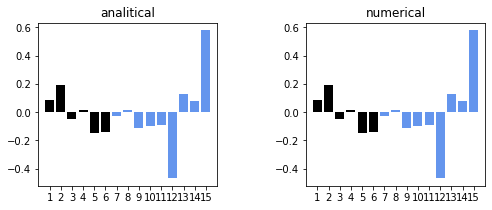

In [65]:
# 오차 역전파법의 구현
# 해석적 미분
def dCE_FNN(wv, M, K, x, t) : 
  N, D = x.shape
  w = wv[:M * (D+1)]
  w = w.reshape(M, (D+1))
  v = wv[M * (D+1):]
  v = v.reshape((K, M+1))

  # x를 입력하여 y를 얻음
  y, a, z, b = FNN(wv, M, K, x)
  # 출력 변수의 준비
  dmv = np.zeros_like(wv)
  dw = np.zeros_like(w)
  dv = np.zeros_like(v)

  delta1 = np.zeros(M)
  delta2 = np.zeros(K)

  for n in range(N) : # 각 데이터마다 한 번씩 실행
    for k in range(K) : # 출력층의 오차 구하기
      delta2[k] = (y[n,k] - t[n,k])

    for j in range(M) : # 출력층의 오차를 활용하여 중간층의 오차 구하기
                        # sigmoid'(x) = sigmoid(x) - (1 - sigmoid(x))
                        # sigmoid(b) = z
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:,j], delta2)
        # delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:,j], delta2) # 둘 다 1차원 배열이라 dot으로 곱해도 하나의 상수가 나온다. 

                                                                   # 즉 상수 * 상수 * 상수 = 상수
    for k in range(K) : # v의 기울기 dv 구하기
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N 
    for j in range(M) : # w의 기울기 dw 구하기
      dw[j, :] = dw[j, :]  + delta1[j] * np.r_[x[n, :], 1] / N
  
  dwv = np.c_[dw.reshape((1, M * ( D + 1 ))), dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv 


# Show VW
def Show_dWV(wv, M) : 
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align='center', color='black')
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3 :], align='center', color='cornflowerblue')
  plt.xticks(range(1, N+1))
  plt.xlim(0, N+1)

# 메인
M = 2
K = 3
N = 2
D = X.shape[1]
nWV = M * (D + 1) + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :]) # 해석적 미분
print("analytical dWV")
print(dWV_ana)


dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
Show_dWV(dWV_ana, M)
plt.title('analitical')

plt.subplot(1,2,2)
Show_dWV(dWV_num, M)
plt.title('numerical')

plt.show()




In [66]:
import time

def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha) : # n은 학습 단계, alpha는 학습률
  wv = wv_init.copy()
  err_train = np.zeros(n) # 각 학습 단계 별로 에러 값을 저장하기 위해서
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001

  for i in range(n) : # 학습 단계의 수만큼 반복
    wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # 매개변수 wvt를 (미분한 값 * 학습률) 만큼 변경시킴
    err_train[i] = CE_FNN(wv, M, K, x_train, t_train) # 매개변수 wvt를 사용하여 train set을 돌렸을 때 나오는 오차
    err_test[i] = CE_FNN(wv, M, K, x_test, t_test)    # 매개변수 wvt를 test set에 적용하였을 때 오차 
    wv_hist[i, :] = wv # 매개변수의 변화 값을 배열에 저장

  return wv, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M+1))
N_step = 1000 # 학습 단계
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime # 계산하는데 걸리는 시간 측정
print("Calculation Time :",calculation_time) # 22초 걸림

Calculation Time : 27.486703634262085


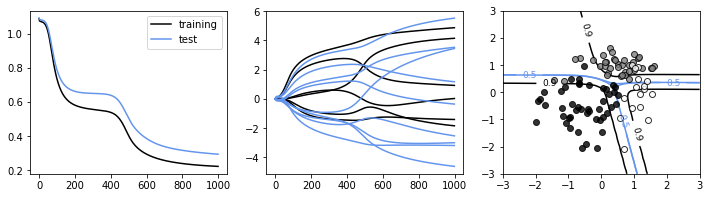

In [67]:
plt.figure(1, figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3 :], 'cornflowerblue')

AX = plt.subplot(1,3,3)
Show_data(AX, X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()